<span style="font-size: 250%;color:white;background:#1155cc"> DLA KLIENTA

<span style="font-size: 240%;color:#1155cc"> WYPOŻYCZALNIA ROWERÓW [weryfikacja jakości modelu]

<span style="font-size: 110%;color:#1155cc">Celem jest wykonanie modelu, który pomógłby w przewidywaniu poziomu pobrań rowerów w wypożyczalni miejskiej.
    
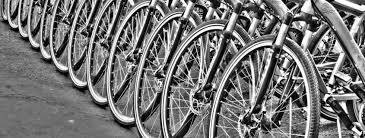    

In [1]:
import numpy as np
import statistics as stat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats
from numpy import median

# Spis zmiennych:

- <span style="font-size: 130%;color:#1155cc"> instant: </span>indeks rekordu
- <span style="font-size: 130%;color:#1155cc">dteday:</span> data
- <span style="font-size: 130%;color:#1155cc">season:</span> sezon (1: wiosenny, 2: lato, 3: jesień, 4: zima)
- <span style="font-size: 130%;color:#1155cc">yr:</span> rok (0: 2011, 1: 2012)
- <span style="font-size: 130%;color:#1155cc">mnth:</span> miesiąc (od 1 do 12)
- <span style="font-size: 130%;color:#1155cc">hr .: </span>godzina (od 0 do 23)
- <span style="font-size: 130%;color:#1155cc">holiday: </span>pogoda jest dniem świątecznym lub nie (pobrane z http://dchr.dc.gov/page/holiday-schedule)
- <span style="font-size: 130%;color:#1155cc">weekday: </span>dzień tygodnia
- <span style="font-size: 130%;color:#1155cc">workingday: </span>jeśli dzień nie jest ani weekendem, ani dniem wolnym od pracy wynosi 1, w przeciwnym razie wynosi 0.
+ <span style="font-size: 130%;color:#1155cc">weathersit:</span>
    - 1: Bezchmurnie, Niewiele chmur, Częściowe zachmurzenie, Częściowe zachmurzenie
    - 2: Mgła + Pochmurno, Mgła + Przerwane chmury, Mgła + Kilka chmur, Mgła
    - 3: lekki śnieg, lekki deszcz + burza z piorunami + rozproszone chmury, lekki deszcz + rozproszone chmury
    - 4: ulewny deszcz + lodowe palety + burza z piorunami + mgła, śnieg + mgła
- <span style="font-size: 130%;color:#1155cc">temp: </span>Znormalizowana temperatura w stopniach Celsjusza. Wartości są podzielone na 41 (maks.)
- <span style="font-size: 130%;color:#1155cc">atemp: </span>Znormalizowana temperatura odczuwania w stopniach Celsjusza. Wartości są podzielone na 50 (maks.)
- <span style="font-size: 130%;color:#1155cc">hum: </span>znormalizowana wilgotność. Wartości są podzielone na 100 (maks.)
- <span style="font-size: 130%;color:#1155cc">windspeed: </span>znormalizowana prędkość wiatru. Wartości są podzielone na 67 (maks.)
- <span style="font-size: 130%;color:#9900ff">casual:</span> liczba przypadkowych użytkowników
- <span style="font-size: 130%;color:#9900ff">registered:</span> liczba zarejestrowanych użytkowników
- <span style="font-size: 130%;color:red">cnt: liczba wszystkich wypożyczonych rowerów, w tym zarówno zwykłych, jak i zarejestrowanych
    
    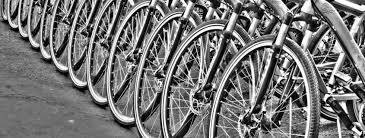

<span style="font-size: 150%;color:#1155cc"> Wgrywam żelazną rezerwę testową

Wyciołem 1% procent ostatnich rekordów, które będa służyły do sprawdzenia zdolności prognostycznych 

In [2]:
df = pd.read_csv('/home/wojciech/Pulpit/7/df5test.csv')

def green(text):
     print('\033[32m', text, '\033[0m', sep='') 

green(df.dtypes)
print()
print()
print(df.shape)

df.head(4)

Unnamed: 0      int64
instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


(173, 18)


,Unnamed: 0,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,17246,17247,2012-12-26,1,1,12,11,0,3,1,3,0.20,0.1667,0.86,0.4627,0,10,10
1,17348,17349,2012-12-30,1,1,12,17,0,0,0,1,0.26,0.2273,0.41,0.3284,26,97,123
2,17266,17267,2012-12-27,1,1,12,7,0,4,1,1,0.24,0.2273,0.70,0.2239,0,90,90
3,17355,17356,2012-12-31,1,1,12,0,0,1,1,1,0.18,0.1818,0.55,0.1940,4,30,34


<span style="font-size: 150%;color:#1155cc"> Sprawdzam czy są braki w danych.

In [3]:
df.isnull().sum()

Unnamed: 0    0
instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [4]:
a,b = df.shape     #<- ile mamy kolumn
b

print('NUMBER OF EMPTY RECORDS vs. FULL RECORDS')
print('----------------------------------------')
for i in range(1,b):
    i = df.columns[i]
    r = df[i].isnull().sum()
    h = df[i].count()
    pr = (r/h)*100
   
    if r > 0:
        print(i,"--------",r,"--------",h,"--------",pr) 

NUMBER OF EMPTY RECORDS vs. FULL RECORDS
----------------------------------------


<span style="font-size: 110%;color:#1155cc">Dane nie mają braków. Szukam czy nie ma błędów. Zmienne nie mają błędów.

In [5]:
df.agg(['min', 'max', 'mean', 'median'])

,Unnamed: 0,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
min,17206.0,17207.0,2012-12-24,1.0,1.0,12.0,0.000000,0.000000,0.000000,0.000000,1.00000,0.140000,0.151500,0.360000,0.000000,0.000000,1.000000,1.000000
max,17378.0,17379.0,2012-12-31,1.0,1.0,12.0,23.000000,1.000000,6.000000,1.000000,3.00000,0.400000,0.409100,1.000000,0.656700,84.000000,246.000000,315.000000
mean,17292.0,17293.0,NaN,1.0,1.0,12.0,11.861272,0.132948,2.936416,0.589595,1.83815,0.251792,0.242423,0.668208,0.226558,13.520231,59.549133,73.069364
median,17292.0,17293.0,NaN,1.0,1.0,12.0,12.000000,0.000000,3.000000,1.000000,2.00000,0.240000,0.242400,0.640000,0.194000,6.000000,37.000000,44.000000


<span style="font-size: 180%;color:#1155cc"> Zmiana formatu zmiennych niezależnych</span> 

Które z tych funkcji są kategoryczne?

Stawiam dwa warunki: 

1. funkcja jest kategoryczna bo ma format 'object'
2. funkcja jest kategoryczna bo ma do 24 unikalnych wartości

In [6]:
a,b = df.shape     #<- ile mamy kolumn
b

print('ONLY DISCRETE FUNCTION')
print('----------------------')
for i in range(1,b):
    i = df.columns[i]
    f = df[i].dtypes
    h = df[i].nunique()
    
    if f == np.object or h<=24:
        print(i,"---",f,"---",h)

ONLY DISCRETE FUNCTION
----------------------
dteday --- object --- 8
season --- int64 --- 1
yr --- int64 --- 1
mnth --- int64 --- 1
hr --- int64 --- 24
holiday --- int64 --- 2
weekday --- int64 --- 7
workingday --- int64 --- 2
weathersit --- int64 --- 3
temp --- float64 --- 14
atemp --- float64 --- 16
windspeed --- float64 --- 21


<span style="font-size: 110%;color:#1155cc">Zmienne dyskretne mają format 'int64' a powinny mieć 'object'.

In [7]:
df.loc[:, 'season':'weathersit'] =  df.loc[:, 'season':'weathersit'].astype('category')

In [8]:
df.dtypes

Unnamed: 0       int64
instant          int64
dteday          object
season        category
yr            category
mnth          category
hr            category
holiday       category
weekday       category
workingday    category
weathersit    category
temp           float64
atemp          float64
hum            float64
windspeed      float64
casual           int64
registered       int64
cnt              int64
dtype: object

<span style="font-size: 180%;color:#1155cc"> Redukcja ilości zmiennych

<span style="font-size: 110%;color:#1155cc">Niektóre kolumny należy usunąć, ponieważ mają wysoki poziom korelacji zmiennych niezależnych (multicollinearity)

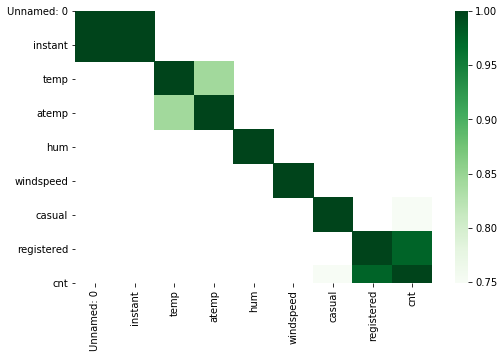

In [9]:
import seaborn as sns

CORR = df.corr()

kot = CORR[CORR>=.7]
plt.figure(figsize=(8,5))
sns.heatmap(kot, cmap="Greens")

<span style="font-size: 110%;color:#1155cc">Na wykresie widać wyraźnie, że zmienne atempt i tempt są zbyt mocno skorelowane. Należy jedną z tych skorelowanych zmiennych wyeliminować.Ponieważ wynik 'cnt' i zmienne 'temp' i 'atemp' mają format ciągły, można zastosować eliminację przez porównanie poziomu korelacji Persona. 

Text(0, 0.5, 'Zmienne nezależne ciągłe')

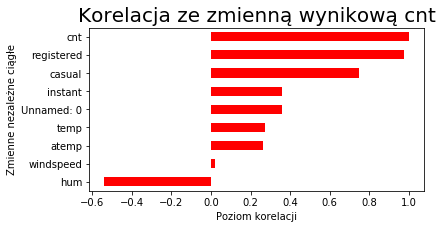

In [10]:
import matplotlib.pyplot as plt

corr = df.corr().sort_values('cnt')
plt.figure(figsize=(6,3))
corr['cnt'].plot(kind='barh', color='red')
plt.title('Korelacja ze zmienną wynikową cnt', fontsize=20)
plt.xlabel('Poziom korelacji')
plt.ylabel('Zmienne nezależne ciągłe')

<span style="font-size: 180%;color:#1155cc"> 'temp', 'atemp', 'instant'</span>

<span style="font-size: 110%;color:#1155cc">Zmienna 'temp' jest bardziej skorelowana niż 'atemp'. Eliminujemy też zmienną 'instant' ponieważ nie ma żadenj wartości poznawczej dla modelu.

In [11]:
df = df.drop(['instant','dteday','Unnamed: 0'], axis=1)

<span style="font-size: 180%;color:#1155cc"> 'casual', 'registered'</span>

<span style="font-size: 110%;color:#1155cc">Zemienne: 'casual', 'registered' na tym etapie nie powinny być brane pod uwage w budowie modelu ponieważ są one zmiennymi wynikowymi.

<span style="font-size: 180%;color:#1155cc"> 'windspeed'</span>

<span style="font-size: 110%;color:#1155cc"> Zmienna: 'windspeed' ma słabą korelację. Siła wiatru przy jeździe rowerem ma wielkie znaczenie. Podejrzewam, że zmienna ta ma znaczenie przy decyzji o wyporzyczeniu roweru ale decyzja ta jest opóźniona o tzn. shift.

<span style="font-size: 180%;color:#1155cc"> Analiza przesunięcia czasowego dla zmiennej 'windspeed'

In [12]:
def cross_corr(x, y, lag=0):
    return x.corr(y.shift(lag))

def shift_Factor(x,y,R):
    x_corr = [cross_corr(x, y, lag=i) for i in range(R)]
    
    # R factor is the number of the shifts who should be checked by the function
    Kot = pd.DataFrame(list(x_corr)).reset_index()
    Kot.rename(columns={0:'Corr', 'index':'Shift_num'}, inplace=True)
    
    # We find optimal correlation shift
    Kot['abs'] = Kot['Corr'].abs()
    SF = Kot.loc[Kot['abs']==Kot['abs'].max(), 'Shift_num']
    p1 = SF.to_frame()
    SF = p1.Shift_num.max()
    
    return SF

In [13]:
x = df.windspeed     # independent variable
y = df['cnt']    # dependent variable
R = 20           # number of shifts who will be checked

In [14]:
SKO = shift_Factor(x,y,R)
print('Optimal shift for RH: ',SKO)
print()
b = cross_corr(x, y, lag=SKO)
a = cross_corr(df['temp'], df['cnt'], lag=SKO)
print('Przed shift: %.3f' %a)
print('Po shift:    %.3f' %b)

Optimal shift for RH:  9

Przed shift: -0.082
Po shift:    0.190


 <span style="font-size: 110%;color:#1155cc"> Teraz dostoswuję bazę do shift. Okazuje się, że klienci rezygnują z wypożyczenie rowerów dopiero po 13 godzinach od nasilenia wiatru ("windspeed"). Zjawisko należałoby dokładnie zbadać. prawdopodobnie klienci jadąc do pracy lub wracając z pracy na rowerze musieli zmagać się z wiatrem i tego samego dnia lub następnego dnia zrezygnowali z wypożyczenia roweru. Ujemna korelacja jest niewielka lecz znacząca -20%. 
    
 <span style="font-size: 110%;color:#1155cc">Tworzę funkcja tworzenia przesunięcia danych.

In [15]:
def df_shif(df, target=None, lag=0):
    if not lag and not target:
        return df       
    new = {}
    for h in df.columns:
        if h == target:
            new[h] = df[target]
        else:
            new[h] = df[h].shift(periods=lag)
    return  pd.DataFrame(data=new)

In [16]:
df2 = df[['temp','hum','windspeed','season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'cnt']]

<span style="font-size: 110%;color:#1155cc"> Tworzę zdublowaną zmienną 'windspeed_shift' z uwzględnieniem przesunięcia 13 godzinnego.

In [17]:
df2['windspeed_shift'] = df2['windspeed']

/home/wojciech/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
df3 = df_shif(df2, 'windspeed_shift', lag=13)
df3.head(7)
## Kasuje dziurę czasową
df3 = df3.dropna(how ='any')
df3.tail(15)

,temp,hum,windspeed,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,cnt,windspeed_shift
158,0.34,0.61,0.0000,1,1,12,19,0,0,0,1,102.0,0.2836
159,0.20,0.55,0.1940,1,1,12,22,0,0,0,1,36.0,0.3582
160,0.26,0.65,0.1343,1,1,12,23,0,1,1,1,49.0,0.1940
161,0.24,0.56,0.1940,1,1,12,12,0,1,1,2,224.0,0.1642
162,0.24,0.52,0.4627,1,1,12,8,0,0,0,1,33.0,0.2537
163,0.16,0.64,0.1940,1,1,12,5,0,1,1,1,9.0,0.2537
164,0.24,0.60,0.0896,1,1,12,5,0,5,1,2,15.0,0.0896
165,0.36,0.50,0.2537,1,1,12,16,1,2,0,2,86.0,0.1343
166,0.26,0.81,0.0000,1,1,12,8,0,6,0,2,44.0,0.2537
167,0.26,0.70,0.1045,1,1,12,6,0,6,0,2,7.0,0.2836


<span style="font-size: 110%;color:#1155cc"> Kasujemy zmienną 'windspeed'.

In [19]:
df3 = df3.drop(['windspeed'], axis=1)

Text(0, 0.5, 'Zmienne nezależne ciągłe')

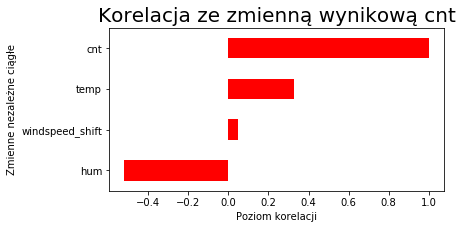

In [20]:
import matplotlib.pyplot as plt

corr = df3.corr().sort_values('cnt')
plt.figure(figsize=(6,3))
corr['cnt'].plot(kind='barh', color='red')
plt.title('Korelacja ze zmienną wynikową cnt', fontsize=20)
plt.xlabel('Poziom korelacji')
plt.ylabel('Zmienne nezależne ciągłe')

<span style="font-size: 110%;color:#1155cc"> Pozostały nam cztery zmienne opisujące. To są zmienne ciągłe. Niestety wiele zmiennych jest dyskretnych i dlatego nie nadają się do modelu regresji liniowej. Te zmienne należy włączyć do modelu regresji poprzez tzw. metodę kodowania na gorąco. 

<span style="font-size: 180%;color:#1155cc"> Przegląd wartości unikalnych dla zmiennych dyskretnych

In [21]:
print(df3['season'].unique())

[1]
Categories (1, int64): [1]


In [22]:
a,b = df3.shape     #<- ile mamy kolumn
b

import numpy as np

for i in range(1,b):
    i = df3.columns[i]
    h = df3[i].nunique()
    f = df3[i].dtypes
          
    print(f,'---nunique->',h,'---name->', i)

float64 ---nunique-> 31 ---name-> hum
category ---nunique-> 1 ---name-> season
category ---nunique-> 1 ---name-> yr
category ---nunique-> 1 ---name-> mnth
category ---nunique-> 24 ---name-> hr
category ---nunique-> 2 ---name-> holiday
category ---nunique-> 7 ---name-> weekday
category ---nunique-> 2 ---name-> workingday
category ---nunique-> 3 ---name-> weathersit
float64 ---nunique-> 102 ---name-> cnt
float64 ---nunique-> 21 ---name-> windspeed_shift


In [23]:
a,b = df3.shape     #<- ile mamy kolumn
b

print('ONLY DISCRETE FUNCTION')
print('----------------------')
for i in range(1,b):
    i = df2.columns[i]
    f = df2[i].dtypes
    h = df2[i].nunique()
    
    if f == np.object or h<=10:
        print(i,"---",f,"---",h)

ONLY DISCRETE FUNCTION
----------------------
season --- category --- 1
yr --- category --- 1
mnth --- category --- 1
holiday --- category --- 2
weekday --- category --- 7
workingday --- category --- 2
weathersit --- category --- 3


<span style="font-size: 110%;color:#1155cc">Wypisuje zmienne, które są dyskretne i które należy kodować na gorąco.

In [24]:
discrete_var = ['season','yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

In [25]:
df3.columns

Index(['temp', 'hum', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'cnt', 'windspeed_shift'],
      dtype='object')

In [26]:
data_dummy = df3

def dummify_dataset(df, col):
    dummy_column = pd.get_dummies(df[col], prefix = col, drop_first = True)
    PKP = pd.concat([df,dummy_column],axis = 1)
    PKP = PKP.drop([col], axis=1)
    return PKP


discrete_var = ['season','yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

for i in range(0,8):
    data_dummy = dummify_dataset(data_dummy,discrete_var[i])

In [27]:
df4 = data_dummy 
df4.sample(3)

,temp,hum,cnt,windspeed_shift,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
125,0.24,0.87,3.0,0.3284,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,0
77,0.24,0.93,11.0,0.1343,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
59,0.24,0.93,23.0,0.2239,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1


In [28]:
df4.columns

Index(['temp', 'hum', 'cnt', 'windspeed_shift', 'hr_1', 'hr_2', 'hr_3', 'hr_4',
       'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12',
       'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20',
       'hr_21', 'hr_22', 'hr_23', 'holiday_1', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'workingday_1',
       'weathersit_2', 'weathersit_3'],
      dtype='object')

<span style="font-size: 180%;color:#1155cc">Deklarowanie zmiennych

In [29]:
X = df4.drop('cnt', axis=1) 
y = df4['cnt'] 

<span style="font-size: 180%;color:#1155cc">Ściąganie modeli z dysku

In [30]:
import joblib
KNeighbors_Regressor = joblib.load('/home/wojciech/Pulpit/7/model1-KNeighbors_Regressor.pkl')
Decision_Tree_Regressor = joblib.load('/home/wojciech/Pulpit/7/model1-Decision_Tree_Regressor.pkl')
Bagging_Regressor = joblib.load('/home/wojciech/Pulpit/7/model1-Bagging_Regressor.pkl')
Gradient_Boosting_Regressor = joblib.load('/home/wojciech/Pulpit/7/model1-Gradient_Boosting_Regressor.pkl')
Linear_Regression = joblib.load('/home/wojciech/Pulpit/7/model1-Linear_Regression.pkl')
AdaBoost_Regressor = joblib.load('/home/wojciech/Pulpit/7/model1-AdaBoost_Regressor.pkl')
Ridge = joblib.load('/home/wojciech/Pulpit/7/model1-Ridge.pkl')
Huber_Regressor = joblib.load('/home/wojciech/Pulpit/7/model1-Huber_Regressor.pkl')
Elastic_Net_CV = joblib.load('/home/wojciech/Pulpit/7/model1-Elastic_Net_CV.pkl')
ExtraTreesRegressor = joblib.load('/home/wojciech/Pulpit/7/model1-ExtraTreesRegressor.pkl')
Random_Forest_Regressor = joblib.load('/home/wojciech/Pulpit/7/model1-Random_Forest_Regressor.pkl')
Support_Vector_Regression = joblib.load('/home/wojciech/Pulpit/7/model1-Support_Vector_Regression.pkl')

<span style="font-size: 180%;color:#1155cc">URUCHOMIAM MODEL 'KNeighbors_Regressor' PO ZGRANIU GO Z DYSKU

In [31]:
KNeighbors_Regressor = KNeighbors_Regressor.fit(X,y)
df4['KNeighbors_Regressor'] = KNeighbors_Regressor.predict(X)

Text(0.5, 1.0, 'COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

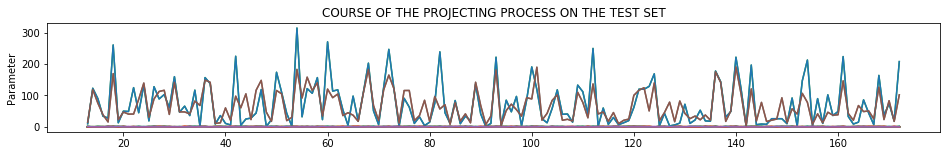

In [32]:
fig, ax = plt.subplots( figsize=(16, 2))
for ewa in ['cnt', 'KNeighbors_Regressor']:
    ax.plot(df4, label=ewa)
    
#ax.set_xlim(1340, 1500)
#ax.legend()
ax.set_ylabel('Parameter')
ax.set_title('COURSE OF THE PROJECTING PROCESS ON THE TEST SET')

# Regression_Assessment

In [33]:
## Robi ocenę tylko dla jednej zmiennej

def Regression_Assessment(y, y_pred):
    
    from sklearn.metrics import r2_score 
    import scipy.stats as stats
    from statsmodels.graphics.gofplots import qqplot
    from matplotlib import pyplot
       
    print('-----two methods--------------')
    SS_Residual = sum((y-y_pred)**2)       
    SS_Total = sum((y-np.mean(y))**2)     
    r_squared = 1 - (float(SS_Residual))/SS_Total
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)
    print('r2_score:           %0.3f' % r_squared)
    #print('adjusted_r_squared: %0.3f' % adjusted_r_squared)
    #print('----r2_score------secound-method--------')  
    print('r2_score:           %0.3f' % r2_score(y, y_pred))  
    print()
    print('-------------------------------')
    MAE = (abs(y-y_pred)).mean()
    print('Mean absolute error     MAE:  %0.2f ' %  MAE)
    RMSE = np.sqrt(((y-y_pred)**2).mean())
    print('Root mean squared error RMSE: %0.2f ' %  RMSE)
    pt = (100*(y-y_pred))/y
    MAPE = (abs(pt)).mean()
    print('Mean absolute error     MAPE: %0.2f ' %  MAPE)
    print('-------------------------------')
    
    stat,pvalue0 = stats.ttest_1samp(a=(y-y_pred),popmean=0.0)

    if pvalue0 > 0.01:
        print('t-test H0: the sum of the model residuals is zero')
        print('OKAY! Model remains do not differ from zero - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue0) 
    else:     
        print('Bad - Model remains DIFFERENT FROM ZERO - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue0)  
    print('--------------------------------------------------------------------------------------------') 
  
       
    stat,pvalue2_1 = stats.shapiro(y)
    stat,pvalue2_2 = stats.shapiro(y_pred)

    if pvalue2_1 > 0.01:
        #print('Shapiro-Wilk H0: y have normal distribution?--------------------------------')
        print('OK Shapiro-Wolf! y have normal distribution - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue2_1) 
    else:     
        print('Bad Shapiro-Wilk - y NO NORMAL DISTRIBUTION - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue2_1)  
        print('--------------------------------------------------------------------------------------------')
    if pvalue2_2 > 0.01:
        #print('Shapiro-Wilk: y_pred have a normal distribution?--')
        print('OK Shapiro-Wolf! y_pred has a normal distribution - pvalue:% 0.4f> 0.01 (we do NOT reject h0)'% pvalue2_2) 
    else:     
        print('Bad Shapiro-Wilk y_pred NO NORMAL DISTRIBUTION - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue2_2)  
    
    qqplot(y, line='s')
    pyplot.show()

    qqplot(y_pred, line='s')
    pyplot.show()
       
    print('--------------------------------------------------------------------------------------------')
        
    stat,pvalue3 = stats.kruskal(y_pred,y)
    stat,pvalue4 = stats.f_oneway(y_pred,y)

    if pvalue2_1 < 0.01 or pvalue2_2 < 0.01:
        print('Шапиро-Вилк: Переменные не имеют нормального распределения! Не могу сделать анализ ANOV')
     
        if pvalue3 > 0.01:
            print('Kruskal-Wallis NON-PARAMETRIC TEST: whether empirical forecast and observations. have equal means?')
            print('OKAY! Kruskal-Wallis H0: forecast and observations empir. have equal means - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue3) 
        else:     
            print('Bad - Kruskal-Wallis: forecast and observations empir. DO NOT HAVE EQUAL Averages - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue3)  
    
    else:

        if pvalue4 > 0.01:
            print('F-test (ANOVA): whether empirical forecast and observations. have equal means?--------------------------------')
            print('OKAY! forecast and observations empir. have equal means - pvalue:% 0.4f> 0.01 (we do NOT reject H0)'% pvalue4) 
        else:     
            print('Bad - forecast and observations empir. DO NOT HAVE EQUAL Averages - pvalue:% 0.4f <0.01 (We reject H0)'% pvalue4)  
    print('--------------------------------------------------------------------------------------------')

In [34]:
pip install py2exe

Note: you may need to restart the kernel to use updated packages.


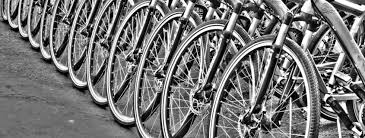 